# Курсовой проект по курсу Спортивный анализ данных. Платформа Kaggle

In [1]:
from typing import List,Optional
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

import missingno as msno

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm
from typing import List, Tuple

In [2]:
DATA_PATH="Data"
def load_data(dataset_name,data_path=DATA_PATH):
    csv_path = os.path.join(data_path,dataset_name)
    data = pd.read_csv(csv_path)
    data.columns=[col.upper() for col in data.columns]
    print("shape = {} rows, {} cols".format(*data.shape))
    return data

In [84]:
train = load_data("train.csv")
test = load_data("test.csv")
client_profile=load_data("client_profile.csv")
#applications_history=load_data("applications_history.csv")
#bki=load_data("bki.csv")
#payments=load_data("payments.csv")

shape = 110093 rows, 3 cols
shape = 165141 rows, 2 cols
shape = 250000 rows, 24 cols


In [4]:
train.describe()

,APPLICATION_NUMBER,TARGET
count,1.100930e+05,110093.000000
mean,1.235772e+08,0.080813
std,8.880939e+04,0.272550
min,1.234233e+08,0.000000
25%,1.235005e+08,0.000000
50%,1.235769e+08,0.000000
75%,1.236539e+08,0.000000
max,1.237308e+08,1.000000


In [5]:
train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash
...,...,...,...
110088,123458312,0,Cash
110089,123672463,0,Cash
110090,123723001,0,Cash
110091,123554358,0,Cash


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
APPLICATION_NUMBER    110093 non-null int64
TARGET                110093 non-null int64
NAME_CONTRACT_TYPE    110093 non-null object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [7]:
train["APPLICATION_NUMBER"].nunique()

110093

In [8]:
test

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card
3,123619984,Cash
4,123671104,Cash
...,...,...
165136,123487967,Cash
165137,123536402,Cash
165138,123718238,Cash
165139,123631557,Cash


**Выводы - поле APPLICATION_NUMBER - просто идентификатор типа ID, который нужен лишь для соединения с другими датасетами**

In [9]:
def target_description_print(ds, target_name):                              
    """
    Печать распределения целевых значений.
    
    Parameters
    ----------
    ds: pd.DataFrame
        Вектор целевой переменной.
    target_name: str
        название целевого поля
    """
    
    values_count_TARGET_0 = ds[ds[target_name]==0].count()[target_name]
    values_count_TARGET_1 = ds[ds[target_name]==1].count()[target_name]
    values_count_TARGET_1_2 = np.around(values_count_TARGET_1/values_count_TARGET_0,3)
    values_count_TARGET_Sum = values_count_TARGET_0+values_count_TARGET_1
    print("TARGET==0 values count =",values_count_TARGET_0)
    print("TARGET==1 values count =",values_count_TARGET_1)
    print("(TARGET==1)count / (TARGET==0)count =",values_count_TARGET_1_2)
    print("TARGET==0 and TARGET==1 in sum values count =",values_count_TARGET_Sum)

In [10]:
target_description_print(train,'TARGET')

TARGET==0 values count = 101196
TARGET==1 values count = 8897
(TARGET==1)count / (TARGET==0)count = 0.088
TARGET==0 and TARGET==1 in sum values count = 110093


#### Создание модели с вновь построенными признаками версия 4

Анализ распределения признаков client_profile

In [11]:
def show_features_distribution(ds, numerical_features, n_rows, n_cols, isTrain, isPlot=True):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    title=''
    if isTrain:
        title = 'train'
    else:
        title = 'test'
    print('Features distribution for {}'.format(title))

    for num, feature in enumerate(numerical_features):
        data = ds[feature].copy()    
        if n_rows==1 and n_cols==1:            
            if isPlot:
                plt.plot(data, color="blue")
            else:
                plt.hist(data,bins=1000, color="blue")
            plt.xlabel(feature, fontsize=12)
        else:            
            if isPlot:
                axes[num%n_rows, num//n_rows].plot(data, color="blue")
            else:
                axes[num%n_rows, num//n_rows].hist(data, bins=1000, color="blue")
            axes[num%n_rows, num//n_rows].set_xlabel(feature, fontsize=12)

In [86]:
numerical_features = client_profile.select_dtypes(exclude=["object"])
numerical_features=numerical_features.drop(["APPLICATION_NUMBER"],axis=1)

In [87]:
numerical_features.describe()

,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,85041.000000,250000.000000,250000.000000,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,67505.883296,12.030221,0.280244,0.057072,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,139261.099609,11.899404,0.449119,0.231981,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,931.000000,5.000000,0.000000,0.000000,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,2217.000000,9.000000,0.000000,0.000000,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,5678.000000,15.000000,1.000000,0.000000,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,1.000000,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [88]:
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 20 columns):
CHILDRENS                     250000 non-null int64
TOTAL_SALARY                  250000 non-null float64
AMOUNT_CREDIT                 250000 non-null float64
AMOUNT_ANNUITY                249989 non-null float64
REGION_POPULATION             250000 non-null float64
AGE                           250000 non-null int64
DAYS_ON_LAST_JOB              250000 non-null int64
OWN_CAR_AGE                   85041 non-null float64
FLAG_PHONE                    250000 non-null int64
FLAG_EMAIL                    250000 non-null int64
FAMILY_SIZE                   249998 non-null float64
EXTERNAL_SCORING_RATING_1     109121 non-null float64
EXTERNAL_SCORING_RATING_2     249468 non-null float64
EXTERNAL_SCORING_RATING_3     200462 non-null float64
AMT_REQ_CREDIT_BUREAU_HOUR    216293 non-null float64
AMT_REQ_CREDIT_BUREAU_DAY     216293 non-null float64
AMT_REQ_CREDIT_BUREAU_WEEK    216293

In [89]:
tmp=pd.DataFrame(data=numerical_features, columns=['DAYS_ON_LAST_JOB','OWN_CAR_AGE','AMT_REQ_CREDIT_BUREAU_QRT'])

Features distribution for train


C:\Users\Windows\.conda\envs\tf\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Windows\.conda\envs\tf\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


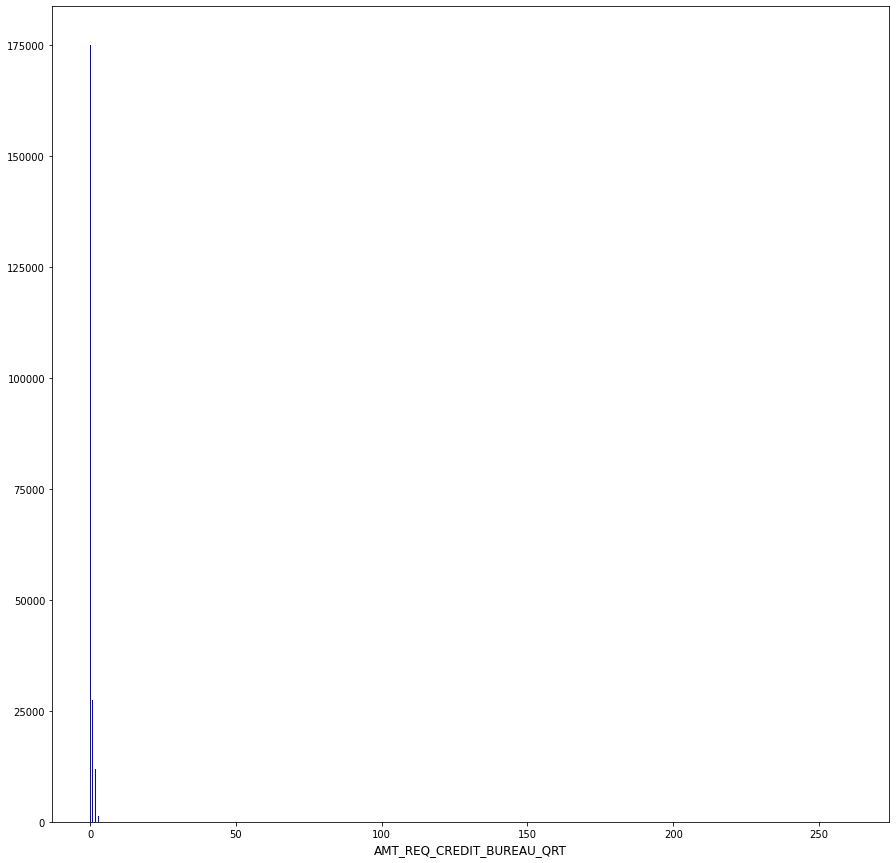

In [90]:
n_cols = 1
n_rows = 1 #len(tmp)//n_cols + 1
show_features_distribution(tmp,['AMT_REQ_CREDIT_BUREAU_QRT'],n_rows, n_cols, isTrain=True, isPlot=False)

In [91]:
numerical_features[numerical_features['AMT_REQ_CREDIT_BUREAU_QRT']>10]['AMT_REQ_CREDIT_BUREAU_QRT'].count()

2

Features distribution for train


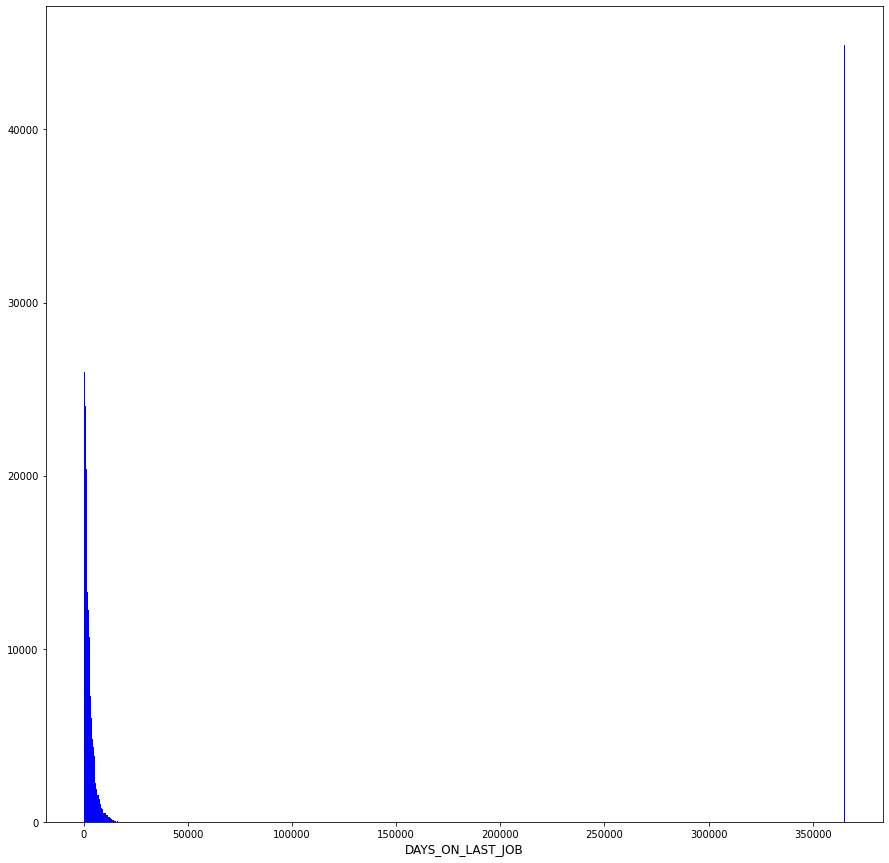

In [92]:
n_cols = 1
n_rows = 1 #len(tmp)//n_cols + 1
show_features_distribution(tmp,['DAYS_ON_LAST_JOB'],n_rows, n_cols, isTrain=True, isPlot=False)

In [93]:
dayes_in_year=365
max_job_duration_years=70

In [94]:
numerical_features[numerical_features['DAYS_ON_LAST_JOB']>dayes_in_year*max_job_duration_years]['DAYS_ON_LAST_JOB'].count()

44867

для DAYS_ON_LAST_JOB и AMT_REQ_CREDIT_BUREAU_QRT - надо удалить выбросы

In [95]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    result = result[result["Total"] != 0]
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [96]:
client_profile_missing = check_missings(client_profile)
client_profile_missing

Total NA-values = 558163


,AMOUNT_ANNUITY,OWN_CAR_AGE,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
Total,11,164959,2,140879,532,49538,33707,33707,33707,33707,33707,33707
Percent,0.0044,65.9836,0.0008,56.3516,0.2128,19.8152,13.4828,13.4828,13.4828,13.4828,13.4828,13.4828
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [97]:
from sklearn.impute import KNNImputer

In [98]:
knn_imputer = KNNImputer(n_neighbors=25, weights="uniform")
client_profile["AMOUNT_ANNUITY"] = knn_imputer.fit_transform(client_profile[["AMOUNT_ANNUITY"]])
client_profile["FAMILY_SIZE"] = knn_imputer.fit_transform(client_profile[["FAMILY_SIZE"]])
client_profile["EXTERNAL_SCORING_RATING_2"] = knn_imputer.fit_transform(client_profile[["EXTERNAL_SCORING_RATING_2"]])

In [99]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [100]:
iterative_imputer = IterativeImputer()
client_profile[numerical_features.columns] = iterative_imputer.fit_transform(client_profile[numerical_features.columns])


In [101]:
client_profile_missing = check_missings(client_profile)
client_profile_missing

Total NA-values = 0


""
Total
Percent
Types


In [102]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          cat_feats,
                          metric: callable,                          
                          cv_strategy,
                          error_to_be_outlier=None,
                          isCatBoost=False
                          ):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        if isCatBoost:
            estimator.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
                          cat_features=cat_feats,plot=True)
        else:
            estimator.fit(X=x_train,y=y_train,
                      eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      early_stopping_rounds=500,
                      eval_metric="auc",
                      verbose=200,
                      categorical_feature=cat_feats)
        
        y_train_pred = estimator.predict_proba(x_train)[:, 1]
        y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

        if not error_to_be_outlier:
            fold_train_scores.append(metric(y_train, y_train_pred))
            fold_valid_scores.append(metric(y_valid, y_valid_pred))
        else: #не работает с классификацией
            mask = ((y_valid - y_valid_pred) / y_valid) < error_to_be_outlier
            fold_valid_scores.append(metric(y_valid[mask], y_valid_pred[mask]))
            mask2 = ((y_train - y_train_pred) / y_train) < error_to_be_outlier
            fold_valid_scores.append(metric(y_train[mask2], y_train_pred[mask2]))

        
        oof_predictions[valid_idx] = y_valid_pred        
        oof_predictions[train_idx] = y_train_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [103]:
def create_client_profile_features(X:pd.DataFrame, copy:bool=True)->pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов
    
    Parameters
    ----------
    X: pd.DataFrame
            исходная матрица признаков с профилем клиента
    copy:bool,optional
            использовать ли копию DF X, по умолчанию=True
    
    Returns 
    -------
    X_transformed:pd.DataFrame
            расширенная матрица признаков с профилем клиента
        
    """
    if copy:
        X=X.copy(deep=True)
        
        
    #AMT_REQ_CREDIT_BUREAU_QRT_max=10
    #X['AMT_REQ_CREDIT_BUREAU_QRT']=np.where(X['AMT_REQ_CREDIT_BUREAU_QRT'] < AMT_REQ_CREDIT_BUREAU_QRT_max,
    #                                        X['AMT_REQ_CREDIT_BUREAU_QRT'],np.nan)
    
    dayes_in_year=365
    max_job_duration_years=70 #предполагаем что макс время работы не более 70 лет
    X['DAYS_ON_LAST_JOB']= np.where(X['DAYS_ON_LAST_JOB'] < dayes_in_year * max_job_duration_years,
                                    X['DAYS_ON_LAST_JOB'],np.nan)
    bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
    X["BKI_REQUESTS_COUNT"] = X[bki_flags].sum(axis=1)
    X["BKI_KURTOSIS"] = X[bki_flags].kurtosis(axis=1)
    X["EXTERNAL_SCORING_PROD"] = X["EXTERNAL_SCORING_RATING_1"] * X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    
    total_ext_scoring_ratings = X["EXTERNAL_SCORING_RATING_1"].sum()+X["EXTERNAL_SCORING_RATING_2"].sum()+X["EXTERNAL_SCORING_RATING_3"].sum()
    ext_scoring_rating_1_ratio=np.ceil((total_ext_scoring_ratings / 3) / client_profile['EXTERNAL_SCORING_RATING_1'].sum())
    ext_scoring_rating_2_ratio=np.ceil((total_ext_scoring_ratings / 3) / client_profile['EXTERNAL_SCORING_RATING_2'].sum())
    ext_scoring_rating_3_ratio=np.ceil((total_ext_scoring_ratings / 3) / client_profile['EXTERNAL_SCORING_RATING_3'].sum())
    X["EXTERNAL_SCORING_WEIGHTED"] = X["EXTERNAL_SCORING_RATING_1"] * ext_scoring_rating_1_ratio + X["EXTERNAL_SCORING_RATING_2"] * ext_scoring_rating_2_ratio + X["EXTERNAL_SCORING_RATING_3"] * ext_scoring_rating_3_ratio

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1","EXTERNAL_SCORING_RATING_2","EXTERNAL_SCORING_RATING_3"]],axis=1)
        
    #Отношение между основными фин. показателями
    X["RATIO_CREDIT_TO_ANNUITY"] = X["AMOUNT_CREDIT"] / X["AMOUNT_ANNUITY"]
    X["RATIO_ANNUITY_TO_SALARY"] = X["AMOUNT_ANNUITY"] / X["TOTAL_SALARY"]
    X["RATIO_CREDIT_TO_SALARY"] = X["AMOUNT_CREDIT"] / X["TOTAL_SALARY"]
    X["TOTAL_SALARY_NET"] = X["TOTAL_SALARY"]-X["AMOUNT_ANNUITY"]
    
    #Отношение фин. показателей к возрасту и врем признакам
    X["RATIO_ANNUITY_TO_AGE"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["RATIO_CREDIT_TO_AGE"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["RATIO_SALARY_TO_AGE"] = X["TOTAL_SALARY"] / X["AGE"]
    X["RATIO_ANNUITY_TO_EXPERIENCE"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CREDIT_TO_EXPERIENCE"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_SALARY_TO_EXPERIENCE"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]

    #Отношение временных признаков
    X["RATIO_AGE_TO_EXPERIENCE"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_SALARY_TO_REGION_POPULATION"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]    
    X["RATIO_CAR_TO_EXPERIENCE"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]    
    X["RATIO_CAR_TO_AGE"] = X["OWN_CAR_AGE"] / X["AGE"]

    #Произведение фин. показателей кредита на вероятность дефолта (мат ожидание дефолта или ожидаемые потери)
    X["EXPECTED_TOTAL_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_MONTHLY_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]

    #м.б закометарены
    
    
    
    X["EXTERNAL_SCORING_RATING_1_PLUS_2"]=np.nansum(
        X[["EXTERNAL_SCORING_RATING_1","EXTERNAL_SCORING_RATING_2"]], axis=1
    )
    X["EXTERNAL_SCORING_RATING_1_PLUS_3"]=np.nansum(
        X[["EXTERNAL_SCORING_RATING_1","EXTERNAL_SCORING_RATING_3"]], axis=1
    )
    
    X["EXTERNAL_SCORING_RATING_2_PLUS_3"]=np.nansum(
        X[["EXTERNAL_SCORING_RATING_2","EXTERNAL_SCORING_RATING_3"]], axis=1
    )
    
    
    
    X["EXTERNAL_SCORING_RATING_1_IS_NAN"]=np.isnan(X["EXTERNAL_SCORING_RATING_1"])
    X["EXTERNAL_SCORING_RATING_2_IS_NAN"]=np.isnan(X["EXTERNAL_SCORING_RATING_2"])
    X["EXTERNAL_SCORING_RATING_3_IS_NAN"]=np.isnan(X["EXTERNAL_SCORING_RATING_3"])
    
    """
    """

    #доп признаки
    X["RATIO_CREDIT_PER_FAMILY_SIZE"] = X["AMOUNT_CREDIT"] / X["FAMILY_SIZE"]
    X["RATIO_CREDIT_PER_CHILDRENS"] = X["AMOUNT_CREDIT"] / (1+X["CHILDRENS"])
    X["RATIO_CHILDRENS_TO_FAMILY_SIZE"] = X["CHILDRENS"] / X["FAMILY_SIZE"]
    X["RATIO_SALARY_PER_FAMILY_SIZE"] = X["TOTAL_SALARY"] / X["FAMILY_SIZE"]
    X["RATIO_SALARY_PER_CHILD"] = X["TOTAL_SALARY"] / X["CHILDRENS"]    
    X["NON_CHILD"] = X["FAMILY_SIZE"] - X["CHILDRENS"]    
    X["RATIO_CHILD_TO_NON_CHILD"] = X["CHILDRENS"] / X["NON_CHILD"]    
    X["RATIO_SALARY_PER_NON_CHILD"] = X["TOTAL_SALARY"] / X["NON_CHILD"]
    X["RATIO_CREDIT_PER_NON_CHILD"] = X["AMOUNT_CREDIT"] / X["NON_CHILD"]
    
    
    
    

    return X
    

In [104]:
client_profile.columns

Index(['APPLICATION_NUMBER', 'GENDER', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'EDUCATION_LEVEL', 'FAMILY_STATUS',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [105]:
client_profile

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0.0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560.0,...,2.0,0.329471,0.236315,0.678568,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
1,123423688,F,0.0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187.0,...,2.0,0.758282,0.442295,0.802745,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2,123501780,M,1.0,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387.0,...,3.0,0.409017,0.738159,0.491579,0.006862,0.006286,0.034368,0.459342,0.241681,1.972518
3,123588799,M,0.0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273.0,...,2.0,0.450509,0.308994,0.590233,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
4,123647485,M,0.0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954.0,...,2.0,0.723691,0.739408,0.156640,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,123657254,M,0.0,216000.0,45000.0,2425.5,Higher education,Married,0.018850,19150.0,...,2.0,0.555436,0.581592,0.048259,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
249996,123645397,M,0.0,103500.0,675000.0,28507.5,Higher education,Married,0.014520,19604.0,...,2.0,0.685357,0.676409,0.726711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
249997,123504053,M,0.0,202500.0,1078200.0,38331.0,Secondary / secondary special,Single / not married,0.031329,8351.0,...,1.0,0.269227,0.353665,0.283712,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
249998,123547316,F,0.0,135000.0,500211.0,38839.5,Secondary / secondary special,Married,0.030755,13277.0,...,2.0,0.305746,0.682462,0.639708,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000


In [106]:
data=pd.concat([train,test],axis=0)
data = data.reset_index(drop=True)

C:\Users\Windows\AppData\Local\Temp/ipykernel_10604/2666864051.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data=pd.concat([train,test],axis=0)


In [107]:
client_profile=create_client_profile_features(client_profile)

In [108]:
data=data.merge(client_profile, how="left", on="APPLICATION_NUMBER")

In [109]:
data.shape

(275234, 70)

In [110]:
def get_splitted_data(data:pd.DataFrame, target_name:str, join_feature_name:str):
                       
    """
    Получить разбивку на train, test, target, test_id, categorical,numerical

    Parameters
    ----------
    data: pd.DataFrame
        Матрица признаков общаяя.
   
    target_name: str
        имя поля целевого признака
    
    join_feature_name: str
        имя поля признака по которому будем соединять тест


    Returns
    -------
    train: pd.DataFrame
        Полная часть - вся учебная выборка.

    test: pd.DataFrame
        Полная часть - вся тестовая выборка.
        
    target:pd.core.series.Series
        значение целевой переменной
        
    test_id:pd.core.series.Series
        значение признака по которому будем соединять тест
    
    categorical: list
        Список имен полей категориальных признаков
    
    numerical: list
        Список имен полей числовых признаков
    
        
    """
    
    mask=data[target_name].isnull()
    feature_to_drop=[join_feature_name,target_name]

    train,test=data.loc[~mask],data.loc[mask]

    target,test_id=train[target_name],test[join_feature_name]
    train=train.drop(feature_to_drop,axis=1)
    test=test.drop(feature_to_drop,axis=1)

    categorical = train.dtypes[train.dtypes=="object"].index.tolist()
    numerical=list(set(train.columns)-set(categorical))

    train=train.replace(np.inf,np.nan)
    train=train.replace(-np.inf,np.nan)
    
    return train, test, target, test_id, categorical,numerical

In [111]:
train, test, target, test_id, categorical,numerical = get_splitted_data(
    data, target_name="TARGET", join_feature_name="APPLICATION_NUMBER")

In [112]:
lgbm_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "n_jobs": 7,
    "seed": 27,
    "early_stopping_rounds":500,
    'num_leaves': 57,
    'max_depth': 8,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 27,
}

In [113]:
train[categorical]=train[categorical].fillna('NA')
test[categorical]=test[categorical].fillna('NA')

In [114]:
for c in categorical:
    train[c] = train[c].astype('category')
for c in categorical:
    test[c] = test[c].astype('category')

In [41]:
 model = lgb.LGBMClassifier(**lgbm_params)

In [42]:
#model,test_prediction=get_samples_hold_out_validation(lgbm_params,train,target,[0.7,0.2,0.1],'LGBM', categorical)
#cv_strategy = KFold(n_splits=20, random_state=42,shuffle=True)
#cv_strategy = StratifiedShuffleSplit(n_splits=20, random_state=29, train_size=0.7)
cv_strategy = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train, target, model, categorical, metric=roc_auc_score,cv_strategy=cv_strategy
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.763778	valid_1's auc: 0.714125
[400]	training's auc: 0.794745	valid_1's auc: 0.720975
[600]	training's auc: 0.818907	valid_1's auc: 0.724648
[800]	training's auc: 0.83728	valid_1's auc: 0.724385
[1000]	training's auc: 0.853685	valid_1's auc: 0.724267
Fold: 1, train-observations = 104588, valid-observations = 5505
train-score = 0.8205, valid-score = 0.7253
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.76439	valid_1's auc: 0.708987
[400]	training's auc: 0.795177	valid_1's auc: 0.720182
[600]	training's auc: 0.819345	valid_1's auc: 0.722238
[800]	training's auc: 0.838071	valid_1's auc: 0.721496
[1000]	training's auc: 0.853672	valid_1's auc: 0.721613
[1200]	training's auc: 0.868552	valid_1's auc: 0.721556
[1400]	training's auc: 0.882609	valid_1's auc: 0.720887
Fold: 2, train-observations = 104588, valid-observations = 5505
train-score = 0.8556, valid-score = 0.7227
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764518	valid_1's auc: 0.729777
[400]	training's auc: 0.795023	valid_1's auc: 0.728227
[600]	training's auc: 0.817831	valid_1's auc: 0.728307
Fold: 3, train-observations = 104588, valid-observations = 5505
train-score = 0.7645, valid-score = 0.7298
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763873	valid_1's auc: 0.722738
[400]	training's auc: 0.794693	valid_1's auc: 0.7308
[600]	training's auc: 0.818078	valid_1's auc: 0.732849
[800]	training's auc: 0.836817	valid_1's auc: 0.732825
[1000]	training's auc: 0.852839	valid_1's auc: 0.734248
[1200]	training's auc: 0.866708	valid_1's auc: 0.733525
[1400]	training's auc: 0.879059	valid_1's auc: 0.73404
Fold: 4, train-observations = 104588, valid-observations = 5505
train-score = 0.8578, valid-score = 0.735
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763852	valid_1's auc: 0.721292
[400]	training's auc: 0.795315	valid_1's auc: 0.727147
[600]	training's auc: 0.820651	valid_1's auc: 0.728892
[800]	training's auc: 0.840483	valid_1's auc: 0.730595
[1000]	training's auc: 0.857289	valid_1's auc: 0.732093
[1200]	training's auc: 0.871711	valid_1's auc: 0.732016
[1400]	training's auc: 0.884016	valid_1's auc: 0.729525
Fold: 5, train-observations = 104588, valid-observations = 5505
train-score = 0.8624, valid-score = 0.7332
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763932	valid_1's auc: 0.720072
[400]	training's auc: 0.794204	valid_1's auc: 0.724287
[600]	training's auc: 0.817141	valid_1's auc: 0.725402
[800]	training's auc: 0.835235	valid_1's auc: 0.72458
[1000]	training's auc: 0.851741	valid_1's auc: 0.723413
Fold: 6, train-observations = 104588, valid-observations = 5505
train-score = 0.8216, valid-score = 0.7257
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.76329	valid_1's auc: 0.728688
[400]	training's auc: 0.794275	valid_1's auc: 0.733198
[600]	training's auc: 0.817262	valid_1's auc: 0.737553
[800]	training's auc: 0.835705	valid_1's auc: 0.737476
[1000]	training's auc: 0.85208	valid_1's auc: 0.740141
[1200]	training's auc: 0.866924	valid_1's auc: 0.741652
[1400]	training's auc: 0.880361	valid_1's auc: 0.741741
[1600]	training's auc: 0.890674	valid_1's auc: 0.742276
[1800]	training's auc: 0.900122	valid_1's auc: 0.741509
[2000]	training's auc: 0.908849	valid_1's auc: 0.743262
[2200]	training's auc: 0.916071	valid_1's auc: 0.7429
[2400]	training's auc: 0.921747	valid_1's auc: 0.742688
Fold: 7, train-observations = 104588, valid-observations = 5505
train-score = 0.9095, valid-score = 0.7443
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.762998	valid_1's auc: 0.73328
[400]	training's auc: 0.794124	valid_1's auc: 0.741468
[600]	training's auc: 0.816972	valid_1's auc: 0.741595
[800]	training's auc: 0.836158	valid_1's auc: 0.74399
[1000]	training's auc: 0.852434	valid_1's auc: 0.740913
[1200]	training's auc: 0.866914	valid_1's auc: 0.741101
Fold: 8, train-observations = 104588, valid-observations = 5505
train-score = 0.8375, valid-score = 0.7441
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763938	valid_1's auc: 0.72068
[400]	training's auc: 0.793707	valid_1's auc: 0.726561
[600]	training's auc: 0.815615	valid_1's auc: 0.727318
[800]	training's auc: 0.834231	valid_1's auc: 0.728993
[1000]	training's auc: 0.852016	valid_1's auc: 0.72898
[1200]	training's auc: 0.86626	valid_1's auc: 0.726883
Fold: 9, train-observations = 104588, valid-observations = 5505
train-score = 0.8415, valid-score = 0.7295
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764002	valid_1's auc: 0.730111
[400]	training's auc: 0.794596	valid_1's auc: 0.736568
[600]	training's auc: 0.818201	valid_1's auc: 0.739867
[800]	training's auc: 0.836942	valid_1's auc: 0.740072
[1000]	training's auc: 0.853161	valid_1's auc: 0.741826
[1200]	training's auc: 0.867109	valid_1's auc: 0.740639
[1400]	training's auc: 0.879673	valid_1's auc: 0.739896
Fold: 10, train-observations = 104588, valid-observations = 5505
train-score = 0.8548, valid-score = 0.7425
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764785	valid_1's auc: 0.721964
[400]	training's auc: 0.795107	valid_1's auc: 0.727716
[600]	training's auc: 0.817184	valid_1's auc: 0.726458
[800]	training's auc: 0.836113	valid_1's auc: 0.725879
Fold: 11, train-observations = 104588, valid-observations = 5505
train-score = 0.801, valid-score = 0.7282
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764744	valid_1's auc: 0.719204
[400]	training's auc: 0.79578	valid_1's auc: 0.721826
[600]	training's auc: 0.818977	valid_1's auc: 0.721934
[800]	training's auc: 0.837052	valid_1's auc: 0.721843
Fold: 12, train-observations = 104588, valid-observations = 5505
train-score = 0.7998, valid-score = 0.7229
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763782	valid_1's auc: 0.731396
[400]	training's auc: 0.794913	valid_1's auc: 0.737393
[600]	training's auc: 0.81815	valid_1's auc: 0.739398
[800]	training's auc: 0.836453	valid_1's auc: 0.739168
Fold: 13, train-observations = 104588, valid-observations = 5505
train-score = 0.8061, valid-score = 0.7397
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764443	valid_1's auc: 0.704685
[400]	training's auc: 0.795315	valid_1's auc: 0.712086
[600]	training's auc: 0.817038	valid_1's auc: 0.714168
[800]	training's auc: 0.835832	valid_1's auc: 0.715223
[1000]	training's auc: 0.852977	valid_1's auc: 0.71634
[1200]	training's auc: 0.86774	valid_1's auc: 0.716561
[1400]	training's auc: 0.880269	valid_1's auc: 0.71686
[1600]	training's auc: 0.891082	valid_1's auc: 0.716548
[1800]	training's auc: 0.900625	valid_1's auc: 0.716913
Fold: 14, train-observations = 104589, valid-observations = 5504
train-score = 0.8843, valid-score = 0.7176
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764421	valid_1's auc: 0.718802
[400]	training's auc: 0.794747	valid_1's auc: 0.72738
[600]	training's auc: 0.818064	valid_1's auc: 0.728256
[800]	training's auc: 0.836061	valid_1's auc: 0.727158
[1000]	training's auc: 0.852746	valid_1's auc: 0.726912
Fold: 15, train-observations = 104589, valid-observations = 5504
train-score = 0.8111, valid-score = 0.7291
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.765157	valid_1's auc: 0.695209
[400]	training's auc: 0.795542	valid_1's auc: 0.702692
[600]	training's auc: 0.818772	valid_1's auc: 0.70346
[800]	training's auc: 0.837361	valid_1's auc: 0.705145
[1000]	training's auc: 0.854112	valid_1's auc: 0.706521
[1200]	training's auc: 0.868327	valid_1's auc: 0.70591
[1400]	training's auc: 0.881274	valid_1's auc: 0.705834
Fold: 16, train-observations = 104589, valid-observations = 5504
train-score = 0.8514, valid-score = 0.7069
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763018	valid_1's auc: 0.737748
[400]	training's auc: 0.794097	valid_1's auc: 0.747469
[600]	training's auc: 0.816939	valid_1's auc: 0.750708
[800]	training's auc: 0.835067	valid_1's auc: 0.753283
[1000]	training's auc: 0.851444	valid_1's auc: 0.754197
[1200]	training's auc: 0.866087	valid_1's auc: 0.753831
[1400]	training's auc: 0.879442	valid_1's auc: 0.75413
Fold: 17, train-observations = 104589, valid-observations = 5504
train-score = 0.8493, valid-score = 0.7552
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763295	valid_1's auc: 0.731741
[400]	training's auc: 0.793626	valid_1's auc: 0.73808
[600]	training's auc: 0.817634	valid_1's auc: 0.736333
[800]	training's auc: 0.836958	valid_1's auc: 0.735738
Fold: 18, train-observations = 104589, valid-observations = 5504
train-score = 0.7959, valid-score = 0.7384
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.764582	valid_1's auc: 0.702302
[400]	training's auc: 0.794954	valid_1's auc: 0.708622
[600]	training's auc: 0.817875	valid_1's auc: 0.712218
[800]	training's auc: 0.836876	valid_1's auc: 0.712186
[1000]	training's auc: 0.853971	valid_1's auc: 0.711947
[1200]	training's auc: 0.868607	valid_1's auc: 0.711314
Fold: 19, train-observations = 104589, valid-observations = 5504
train-score = 0.8294, valid-score = 0.7132
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763157	valid_1's auc: 0.726793
[400]	training's auc: 0.794058	valid_1's auc: 0.733213
[600]	training's auc: 0.816977	valid_1's auc: 0.734675
[800]	training's auc: 0.835793	valid_1's auc: 0.734631
[1000]	training's auc: 0.852428	valid_1's auc: 0.734497
[1200]	training's auc: 0.866329	valid_1's auc: 0.734559
Fold: 20, train-observations = 104589, valid-observations = 5504
train-score = 0.8273, valid-score = 0.7358
CV-results train: 0.8341 +/- 0.033
CV-results valid: 0.731 +/- 0.011
OOF-score = 0.8228


In [43]:
fold_number_max_score = np.argmax(fold_valid_scores)

In [44]:
np.max(fold_valid_scores)

0.7552454075615601

In [45]:
best_model_lgb=estimators[fold_number_max_score]

In [46]:
test_predict_target=best_model_lgb.predict_proba(test)[:,1]  

Оценим важности признаков и уберем малозначащие признаки из модели

In [47]:
def get_train_valid_test_data(data,target):
    x_train, x_valid = train_test_split(
        data, train_size=0.7, shuffle=True, random_state=1
    )
    y_train, y_valid = train_test_split(
        target, train_size=0.7, shuffle=True, random_state=1
    )

    x_valid, x_test = train_test_split(
        x_valid, train_size=0.7, shuffle=True, random_state=27
    )
    y_valid, y_test = train_test_split(
        y_valid, train_size=0.7, shuffle=True, random_state=27
    )

    print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
    print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
    print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
    return x_train, x_valid,x_test, y_train, y_valid,y_test

In [154]:
x_train, x_valid,x_test, y_train, y_valid,y_test=get_train_valid_test_data(train,target)

x_train.shape = 77065 rows, 68 cols
x_valid.shape = 23119 rows, 68 cols
x_test.shape = 9909 rows, 68 cols


In [146]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.

    """
    y_pred = _predict(estimator, x_valid)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])
        for c in categorical:
            x_valid_[c] = x_valid_[c].astype('category')

        y_pred = _predict(estimator, x_valid_)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [149]:
scores, importance = calculate_permutation_importance(
    best_model_lgb, roc_auc_score, train, target
)

100%|██████████| 68/68 [02:06<00:00,  1.86s/it]


In [150]:
importance

RATIO_CREDIT_TO_ANNUITY             0.034556
AGE                                 0.012812
EDUCATION_LEVEL                     0.012471
NAME_CONTRACT_TYPE                  0.009123
GENDER                              0.008667
                                      ...   
CHILDRENS                           0.000052
EXTERNAL_SCORING_RATING_1_IS_NAN    0.000000
EXTERNAL_SCORING_RATING_2_IS_NAN    0.000000
EXTERNAL_SCORING_RATING_3_IS_NAN    0.000000
EXTERNAL_SCORING_PROD              -0.000041
Length: 68, dtype: float64

Посмотрим важность признаков по алгоритму,  встроенному в модель для сравнения

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

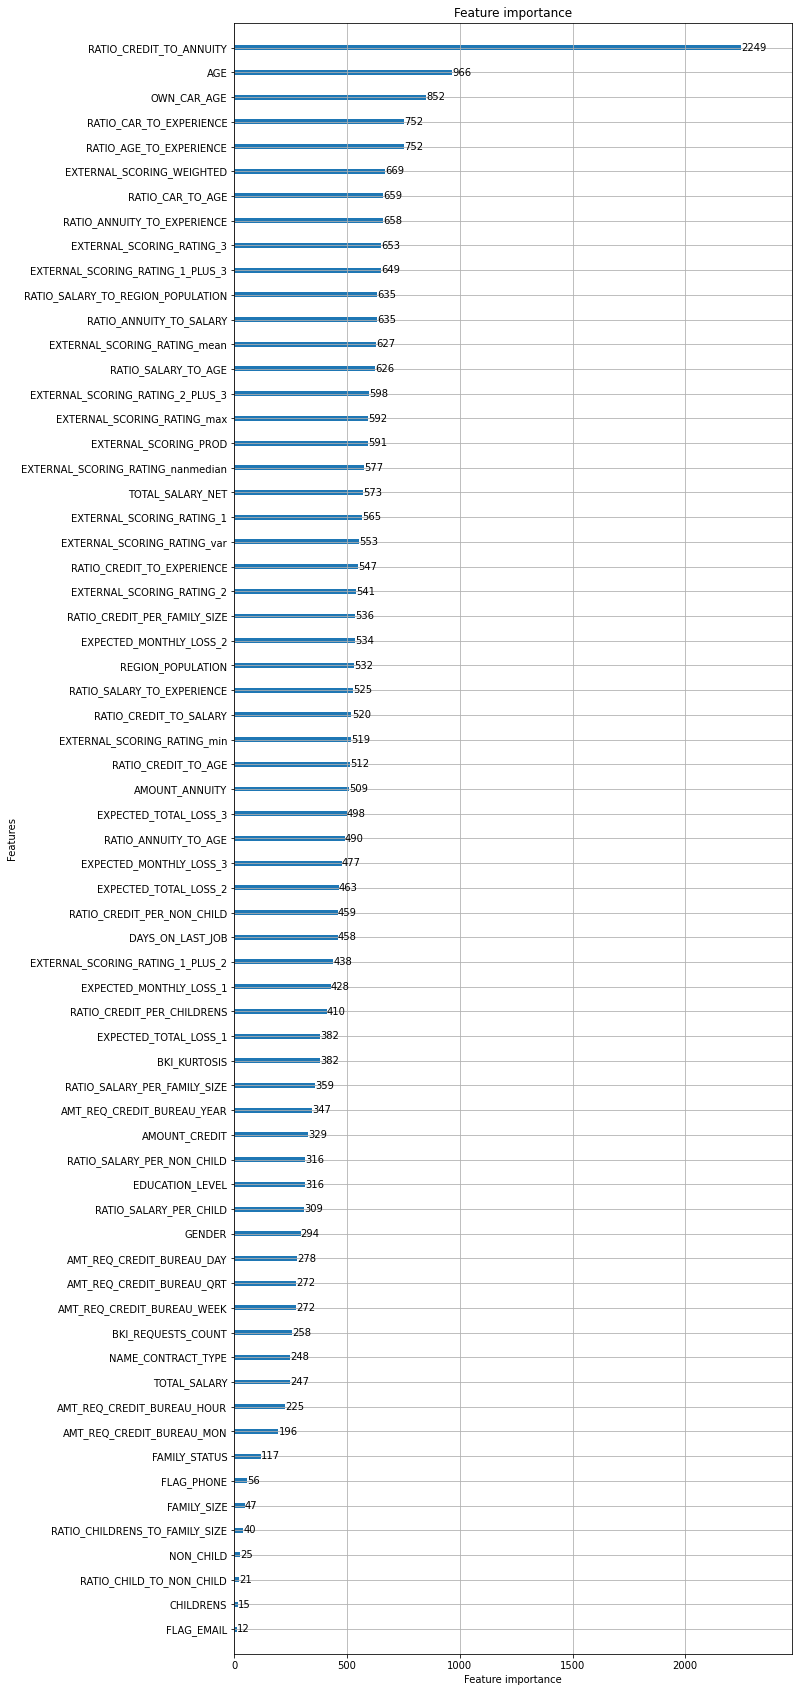

In [47]:
lgb.plot_importance(best_model_lgb,max_num_features=200,figsize=(10,30))

In [48]:
len(best_model_lgb.feature_importances_)

68

Уберем последние 4 признака, которые по существу мало влияют на качество модели и снова обучим модель

In [151]:
train_only_imp_features=train.drop(["CHILDRENS","EXTERNAL_SCORING_RATING_1_IS_NAN","EXTERNAL_SCORING_RATING_2_IS_NAN","EXTERNAL_SCORING_RATING_3_IS_NAN","EXTERNAL_SCORING_PROD"],axis=1)

In [152]:
test_only_imp_features=test.drop(["CHILDRENS","EXTERNAL_SCORING_RATING_1_IS_NAN","EXTERNAL_SCORING_RATING_2_IS_NAN","EXTERNAL_SCORING_RATING_3_IS_NAN","EXTERNAL_SCORING_PROD"],axis=1)

Оптимизируем параметры модели и снова обучим модель

In [153]:
!pip install bayesian-optimization

You should consider upgrading via the 'C:\Users\Windows\.conda\envs\tf\python.exe -m pip install --upgrade pip' command.


In [155]:
from bayes_opt import BayesianOptimization

In [156]:
x_train, x_valid,x_test, y_train, y_valid,y_test=get_train_valid_test_data(train_only_imp_features,target)

x_train.shape = 77065 rows, 63 cols
x_valid.shape = 23119 rows, 63 cols
x_test.shape = 9909 rows, 63 cols


In [159]:
categorical

['NAME_CONTRACT_TYPE',
 'GENDER',
 'EDUCATION_LEVEL',
 'FAMILY_STATUS',
 'EXTERNAL_SCORING_RATING_1_IS_NAN',
 'EXTERNAL_SCORING_RATING_2_IS_NAN',
 'EXTERNAL_SCORING_RATING_3_IS_NAN']

In [160]:
categorical.remove('EXTERNAL_SCORING_RATING_1_IS_NAN')
categorical.remove('EXTERNAL_SCORING_RATING_2_IS_NAN')
categorical.remove('EXTERNAL_SCORING_RATING_3_IS_NAN')

In [161]:
def lgboost_optimize_params(max_depth, colsample_bytree, num_leaves, min_data_in_leaf,
                            min_child_weight):

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'n_estimators': 9000,
        'n_jobs': 7,
        'seed': 27,
        'early_stopping_rounds':500,
        'num_leaves': 57,
        'max_depth': 9,
        'subsample_for_bin': 240000,
        'lambda_l1': 0.436193,
        'lambda_l2': 0.479169,
        'colsample_bytree': 0.508716,
        'min_split_gain': 0.024766,
        'subsample': 0.7,
        'is_unbalance': False,
        'random_state': 27,
        'extra_trees':False,
        'min_data_in_leaf':20,
        'min_child_weight': 0.001,
        'subsample_freq':0
    }
    
    params["max_depth"] = int(max_depth)  
    params["colsample_bytree"] = colsample_bytree
    params["num_leaves"] = int(num_leaves)   
    params["min_data_in_leaf"] = int(min_data_in_leaf)
    params["min_child_weight"] = min_child_weight
       
    
    model = lgb.LGBMClassifier(**params)
    
    model.fit(X=x_train,y=y_train,
                      eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      early_stopping_rounds=500,
                      eval_metric="auc",
                      verbose=200,
                      categorical_feature=categorical)
 
    return roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])

In [162]:
params_search = {
    "max_depth": (6, 10),    
    "colsample_bytree": (0.3, 0.9),
    "num_leaves": (10,100),     
    'min_data_in_leaf': (10,256),
    'min_child_weight':(0.0005,0.05)  
}

optimizer = BayesianOptimization(
    f=lgboost_optimize_params,
    pbounds=params_search,
    random_state=27
)
optimizer.maximize(
    init_points=7, n_iter=20, acq='ei'
)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=223, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=223
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.762122	valid_1's auc: 0.721039
[400]	training's auc: 0.789293	valid_1's auc: 0.724755
[600]	training's auc: 0.808394	valid_1's auc: 0.724494
[800]	training's auc: 0.825568	valid_1's auc: 0.724606
|  1        |  0.7254   |  0.5554   |  9.258    |  0.0369   |  223.5    |  44.5     |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=192, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=192
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.783075	valid_1's auc: 0.720437
[400]	training's auc: 0.816689	valid_1's auc: 0.723161
[600]	training's auc: 0.838006	valid_1's auc: 0.72341
[800]	training's auc: 0.857088	valid_1's auc: 0.723419
[1000]	training's auc: 0.874525	valid_1's auc: 0.723823
[1200]	training's auc: 0.888696	valid_1's auc: 0.722947
[1400]	training's auc: 0.901484	valid_1's auc: 0.723009
|  2        |  0.7243   |  0.8877   |  9.573    |  0.01088  |  192.5    |  69.68    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=224, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=224
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 wil

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.745009	valid_1's auc: 0.718693
[400]	training's auc: 0.766281	valid_1's auc: 0.723903
[600]	training's auc: 0.782788	valid_1's auc: 0.724512
[800]	training's auc: 0.796299	valid_1's auc: 0.725194
[1000]	training's auc: 0.809227	valid_1's auc: 0.725709
[1200]	training's auc: 0.820996	valid_1's auc: 0.725614
[1400]	training's auc: 0.832282	valid_1's auc: 0.725752
[1600]	training's auc: 0.84233	valid_1's auc: 0.725298
[1800]	training's auc: 0.853091	valid_1's auc: 0.725013
|  3        |  0.726    |  0.8321   |  9.432    |  0.03759  |  224.1    |  26.81    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.744171	valid_1's auc: 0.718941
[400]	training's auc: 0.765967	valid_1's auc: 0.724071
[600]	training's auc: 0.781937	valid_1's auc: 0.725572
[800]	training's auc: 0.795423	valid_1's auc: 0.725578
[1000]	training's auc: 0.808332	valid_1's auc: 0.725595
|  4        |  0.726    |  0.4953   |  7.492    |  0.03979  |  47.16    |  25.29    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.733142	valid_1's auc: 0.717368
[400]	training's auc: 0.750009	valid_1's auc: 0.723912
[600]	training's auc: 0.762136	valid_1's auc: 0.725513
[800]	training's auc: 0.771832	valid_1's auc: 0.725788
[1000]	training's auc: 0.780843	valid_1's auc: 0.726492
[1200]	training's auc: 0.789514	valid_1's auc: 0.726655
[1400]	training's auc: 0.797608	valid_1's auc: 0.726485
[1600]	training's auc: 0.80569	valid_1's auc: 0.726764
[1800]	training's auc: 0.813112	valid_1's auc: 0.727415
[2000]	training's auc: 0.820115	valid_1's auc: 0.727177
[2200]	training's auc: 0.827134	valid_1's auc: 0.726763
|  5        |  0.7277   |  0.3487   |  7.221    |  0.03927  |  50.07    |  16.36    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=112, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=112
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.763481	valid_1's auc: 0.718937
[400]	training's auc: 0.787383	valid_1's auc: 0.722333
[600]	training's auc: 0.801393	valid_1's auc: 0.723923
[800]	training's auc: 0.81411	valid_1's auc: 0.724106
[1000]	training's auc: 0.827169	valid_1's auc: 0.724131
|  6        |  0.7245   |  0.7206   |  6.724    |  0.03015  |  112.2    |  56.22    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=238, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=238
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.782198	valid_1's auc: 0.721145
[400]	training's auc: 0.809548	valid_1's auc: 0.725617
[600]	training's auc: 0.826425	valid_1's auc: 0.726251
[800]	training's auc: 0.840884	valid_1's auc: 0.726081
[1000]	training's auc: 0.855609	valid_1's auc: 0.727095
[1200]	training's auc: 0.868677	valid_1's auc: 0.726914
[1400]	training's auc: 0.880459	valid_1's auc: 0.727441
[1600]	training's auc: 0.890854	valid_1's auc: 0.726352
[1800]	training's auc: 0.900148	valid_1's auc: 0.725336
|  7        |  0.7277   |  0.4324   |  8.902    |  0.04255  |  238.5    |  76.23    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Curren

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.733152	valid_1's auc: 0.717935
[400]	training's auc: 0.750002	valid_1's auc: 0.723885
[600]	training's auc: 0.761438	valid_1's auc: 0.725448
[800]	training's auc: 0.770512	valid_1's auc: 0.726112
[1000]	training's auc: 0.780193	valid_1's auc: 0.725962
[1200]	training's auc: 0.788655	valid_1's auc: 0.725864
|  8        |  0.7265   |  0.4891   |  6.253    |  0.03597  |  49.79    |  16.59    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=237, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=237
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.784031	valid_1's auc: 0.721154
[400]	training's auc: 0.815882	valid_1's auc: 0.72586
[600]	training's auc: 0.834503	valid_1's auc: 0.726576
[800]	training's auc: 0.851575	valid_1's auc: 0.726625
[1000]	training's auc: 0.867619	valid_1's auc: 0.726561
[1200]	training's auc: 0.881291	valid_1's auc: 0.726576
|  9        |  0.7268   |  0.4298   |  9.723    |  0.01374  |  237.6    |  75.66    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.732639	valid_1's auc: 0.717206
[400]	training's auc: 0.749166	valid_1's auc: 0.723946
[600]	training's auc: 0.760534	valid_1's auc: 0.725096
[800]	training's auc: 0.77027	valid_1's auc: 0.724901
[1000]	training's auc: 0.779326	valid_1's auc: 0.725254
|  10       |  0.7256   |  0.6454   |  7.938    |  0.04815  |  51.19    |  15.78    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.732994	valid_1's auc: 0.717839
[400]	training's auc: 0.749815	valid_1's auc: 0.723822
[600]	training's auc: 0.761813	valid_1's auc: 0.725944
[800]	training's auc: 0.771459	valid_1's auc: 0.725749
[1000]	training's auc: 0.780859	valid_1's auc: 0.725579
|  11       |  0.7261   |  0.3291   |  7.029    |  0.01125  |  49.96    |  16.53    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.732922	valid_1's auc: 0.717349
[400]	training's auc: 0.749212	valid_1's auc: 0.723428
[600]	training's auc: 0.760682	valid_1's auc: 0.72514
[800]	training's auc: 0.770057	valid_1's auc: 0.725614
[1000]	training's auc: 0.77945	valid_1's auc: 0.725871
[1200]	training's auc: 0.787701	valid_1's auc: 0.725432
[1400]	training's auc: 0.795648	valid_1's auc: 0.725791
|  12       |  0.7262   |  0.3554   |  6.576    |  0.03594  |  49.77    |  16.58    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.7256	valid_1's auc: 0.715411
[400]	training's auc: 0.739075	valid_1's auc: 0.721965
[600]	training's auc: 0.747118	valid_1's auc: 0.723848
[800]	training's auc: 0.753972	valid_1's auc: 0.724303
[1000]	training's auc: 0.759556	valid_1's auc: 0.723886
[1200]	training's auc: 0.764814	valid_1's auc: 0.724109
[1400]	training's auc: 0.769973	valid_1's auc: 0.724887
[1600]	training's auc: 0.775879	valid_1's auc: 0.724848
[1800]	training's auc: 0.781282	valid_1's auc: 0.725095
[2000]	training's auc: 0.786495	valid_1's auc: 0.725395
[2200]	training's auc: 0.791259	valid_1's auc: 0.725844
[2400]	training's auc: 0.795937	valid_1's auc: 0.72538
[2600]	training's auc: 0.800953	valid_1's auc: 0.725287
|  13       |  0.7259   |  0.6205   |  7.004    |  0.02051  |  135.5    |  10.27    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current valu

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.776112	valid_1's auc: 0.72093
[400]	training's auc: 0.803715	valid_1's auc: 0.725282
[600]	training's auc: 0.821861	valid_1's auc: 0.725837
[800]	training's auc: 0.835357	valid_1's auc: 0.726267
[1000]	training's auc: 0.849234	valid_1's auc: 0.727168
[1200]	training's auc: 0.862167	valid_1's auc: 0.727069
[1400]	training's auc: 0.873922	valid_1's auc: 0.726941
|  14       |  0.7275   |  0.3668   |  7.894    |  0.0342   |  126.1    |  69.77    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 wil

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.781169	valid_1's auc: 0.719849
[400]	training's auc: 0.810626	valid_1's auc: 0.723558
[600]	training's auc: 0.827184	valid_1's auc: 0.724532
[800]	training's auc: 0.841624	valid_1's auc: 0.724956
[1000]	training's auc: 0.856082	valid_1's auc: 0.725443
[1200]	training's auc: 0.869872	valid_1's auc: 0.725452
[1400]	training's auc: 0.881737	valid_1's auc: 0.724599
[1600]	training's auc: 0.892393	valid_1's auc: 0.725014
|  15       |  0.726    |  0.682    |  7.655    |  0.04589  |  108.6    |  70.36    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_s

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.782146	valid_1's auc: 0.719181
[400]	training's auc: 0.819328	valid_1's auc: 0.72348
[600]	training's auc: 0.846029	valid_1's auc: 0.723838
[800]	training's auc: 0.868849	valid_1's auc: 0.723583
[1000]	training's auc: 0.886884	valid_1's auc: 0.723563
[1200]	training's auc: 0.901839	valid_1's auc: 0.723671
[1400]	training's auc: 0.913459	valid_1's auc: 0.722705
[1600]	training's auc: 0.922909	valid_1's auc: 0.722404
|  16       |  0.7242   |  0.6579   |  9.676    |  0.04021  |  50.18    |  61.02    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.768587	valid_1's auc: 0.71972
[400]	training's auc: 0.79714	valid_1's auc: 0.723855
[600]	training's auc: 0.814222	valid_1's auc: 0.724939
[800]	training's auc: 0.829396	valid_1's auc: 0.725153
[1000]	training's auc: 0.844755	valid_1's auc: 0.724282
[1200]	training's auc: 0.858039	valid_1's auc: 0.724359
|  17       |  0.7255   |  0.746    |  7.732    |  0.02754  |  116.0    |  52.19    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=251, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=251
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.771462	valid_1's auc: 0.720447
[400]	training's auc: 0.800543	valid_1's auc: 0.724224
[600]	training's auc: 0.819977	valid_1's auc: 0.724392
[800]	training's auc: 0.837227	valid_1's auc: 0.724288
[1000]	training's auc: 0.852253	valid_1's auc: 0.724692
[1200]	training's auc: 0.867212	valid_1's auc: 0.72472
[1400]	training's auc: 0.879895	valid_1's auc: 0.724237
|  18       |  0.7256   |  0.565    |  9.022    |  0.000914 |  251.2    |  56.33    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=238, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=238
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 wil

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.786338	valid_1's auc: 0.720878
[400]	training's auc: 0.817204	valid_1's auc: 0.724177
[600]	training's auc: 0.835939	valid_1's auc: 0.72426
[800]	training's auc: 0.854626	valid_1's auc: 0.724296
[1000]	training's auc: 0.87007	valid_1's auc: 0.724103
[1200]	training's auc: 0.884036	valid_1's auc: 0.723666
[1400]	training's auc: 0.894926	valid_1's auc: 0.72371
|  19       |  0.7247   |  0.5616   |  9.255    |  0.01908  |  238.3    |  76.06    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.778304	valid_1's auc: 0.719952
[400]	training's auc: 0.812487	valid_1's auc: 0.723442
[600]	training's auc: 0.836438	valid_1's auc: 0.723478
[800]	training's auc: 0.858176	valid_1's auc: 0.723025
[1000]	training's auc: 0.876646	valid_1's auc: 0.721833
|  20       |  0.7243   |  0.8689   |  9.042    |  0.04862  |  99.98    |  59.15    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=211, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=211
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.777032	valid_1's auc: 0.720552
[400]	training's auc: 0.808472	valid_1's auc: 0.725024
[600]	training's auc: 0.828892	valid_1's auc: 0.725955
[800]	training's auc: 0.845545	valid_1's auc: 0.725608
[1000]	training's auc: 0.863145	valid_1's auc: 0.726258
[1200]	training's auc: 0.878628	valid_1's auc: 0.726174
[1400]	training's auc: 0.891076	valid_1's auc: 0.725493
[1600]	training's auc: 0.901423	valid_1's auc: 0.725017
|  21       |  0.7268   |  0.4893   |  9.721    |  0.02708  |  211.2    |  63.51    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.733647	valid_1's auc: 0.717552
[400]	training's auc: 0.749921	valid_1's auc: 0.723865
[600]	training's auc: 0.761742	valid_1's auc: 0.724862
[800]	training's auc: 0.771184	valid_1's auc: 0.725097
[1000]	training's auc: 0.780221	valid_1's auc: 0.725083
[1200]	training's auc: 0.789076	valid_1's auc: 0.725079
[1400]	training's auc: 0.796633	valid_1's auc: 0.725212
[1600]	training's auc: 0.804535	valid_1's auc: 0.724972
[1800]	training's auc: 0.812456	valid_1's auc: 0.725108
[2000]	training's auc: 0.820018	valid_1's auc: 0.72535
[2200]	training's auc: 0.827663	valid_1's auc: 0.724909
[2400]	training's auc: 0.834361	valid_1's auc: 0.724656
|  22       |  0.7256   |  0.6708   |  8.507    |  0.03891  |  145.1    |  16.7     |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=218, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=218
[LightGBM] [Warning] lambda_l1

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.767357	valid_1's auc: 0.719398
[400]	training's auc: 0.793465	valid_1's auc: 0.724136
[600]	training's auc: 0.808464	valid_1's auc: 0.723829
[800]	training's auc: 0.82216	valid_1's auc: 0.724421
|  23       |  0.7252   |  0.7276   |  7.851    |  0.02544  |  218.8    |  53.2     |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.776501	valid_1's auc: 0.720689
[400]	training's auc: 0.804487	valid_1's auc: 0.725162
[600]	training's auc: 0.821174	valid_1's auc: 0.726284
[800]	training's auc: 0.834974	valid_1's auc: 0.726974
[1000]	training's auc: 0.849142	valid_1's auc: 0.727508
[1200]	training's auc: 0.862673	valid_1's auc: 0.726845
[1400]	training's auc: 0.87476	valid_1's auc: 0.726869
|  24       |  0.7279   |  0.3845   |  7.932    |  0.02963  |  126.5    |  69.4     |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will 

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.733662	valid_1's auc: 0.717539
[400]	training's auc: 0.750704	valid_1's auc: 0.723757
[600]	training's auc: 0.762575	valid_1's auc: 0.724977
[800]	training's auc: 0.772468	valid_1's auc: 0.725593
[1000]	training's auc: 0.78189	valid_1's auc: 0.725459
[1200]	training's auc: 0.791067	valid_1's auc: 0.725153
[1400]	training's auc: 0.79889	valid_1's auc: 0.724702
|  25       |  0.7259   |  0.509    |  7.202    |  0.01147  |  50.2     |  16.92    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.777641	valid_1's auc: 0.720869
[400]	training's auc: 0.806593	valid_1's auc: 0.725649
[600]	training's auc: 0.82437	valid_1's auc: 0.725677
[800]	training's auc: 0.839438	valid_1's auc: 0.727063
[1000]	training's auc: 0.853913	valid_1's auc: 0.727576
[1200]	training's auc: 0.866905	valid_1's auc: 0.727257
[1400]	training's auc: 0.878797	valid_1's auc: 0.726627
|  26       |  0.7278   |  0.413    |  7.08     |  0.03609  |  108.4    |  69.83    |
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 wil

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.779131	valid_1's auc: 0.720811
[400]	training's auc: 0.807821	valid_1's auc: 0.723736
[600]	training's auc: 0.82587	valid_1's auc: 0.725033
[800]	training's auc: 0.840696	valid_1's auc: 0.725456
[1000]	training's auc: 0.855404	valid_1's auc: 0.725529
[1200]	training's auc: 0.86936	valid_1's auc: 0.725955
[1400]	training's auc: 0.881195	valid_1's auc: 0.725722
[1600]	training's auc: 0.891369	valid_1's auc: 0.725083
[1800]	training's auc: 0.900513	valid_1's auc: 0.724688
|  27       |  0.7264   |  0.5265   |  7.496    |  0.01786  |  108.1    |  69.63    |


In [163]:
optimal_lgb_params = optimizer.max

In [164]:
optimal_lgb_params

{'target': 0.7278843311239281,
 'params': {'colsample_bytree': 0.38451716820947596,
  'max_depth': 7.9319049115438,
  'min_child_weight': 0.029626596863790836,
  'min_data_in_leaf': 126.54263310829822,
  'num_leaves': 69.3970383153434}}

In [165]:
optimal_lgb_params["params"]["max_depth"]=int(np.round(optimal_lgb_params["params"]["max_depth"]))
optimal_lgb_params["params"]["num_leaves"]=int(np.round(optimal_lgb_params["params"]["num_leaves"]))
optimal_lgb_params["params"]["min_data_in_leaf"]=int(np.round(optimal_lgb_params["params"]["min_data_in_leaf"]))


In [166]:
optimal_lgb_params

{'target': 0.7278843311239281,
 'params': {'colsample_bytree': 0.38451716820947596,
  'max_depth': 8,
  'min_child_weight': 0.029626596863790836,
  'min_data_in_leaf': 127,
  'num_leaves': 69}}

In [167]:
lgbm_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'n_estimators': 9000,
        'n_jobs': 7,
        'seed': 27,
        'early_stopping_rounds':500,
        'num_leaves': 57,
        'max_depth': 9,
        'subsample_for_bin': 240000,
        'lambda_l1': 0.436193,
        'lambda_l2': 0.479169,
        'colsample_bytree': 0.508716,
        'min_split_gain': 0.024766,
        'subsample': 0.7,
        'is_unbalance': False,
        'random_state': 27,
        'extra_trees':False,
        'min_data_in_leaf':20,
        'min_child_weight': 0.001,
        'subsample_freq':0
    
 }

In [168]:
for optimal_lgb_param_name in optimal_lgb_params["params"]:
    lgbm_params[optimal_lgb_param_name]=optimal_lgb_params["params"][optimal_lgb_param_name]
    

In [169]:
lgbm_params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': 'auc',
 'learning_rate': 0.01,
 'n_estimators': 9000,
 'n_jobs': 7,
 'seed': 27,
 'early_stopping_rounds': 500,
 'num_leaves': 69,
 'max_depth': 8,
 'subsample_for_bin': 240000,
 'lambda_l1': 0.436193,
 'lambda_l2': 0.479169,
 'colsample_bytree': 0.38451716820947596,
 'min_split_gain': 0.024766,
 'subsample': 0.7,
 'is_unbalance': False,
 'random_state': 27,
 'extra_trees': False,
 'min_data_in_leaf': 127,
 'min_child_weight': 0.029626596863790836,
 'subsample_freq': 0}

Используется BayesianOptimization

In [170]:
model = lgb.LGBMClassifier(**lgbm_params)

In [171]:
#model,test_prediction=get_samples_hold_out_validation(lgbm_params,train,target,[0.7,0.2,0.1],'LGBM', categorical)
#cv_strategy = KFold(n_splits=20, random_state=42,shuffle=True)
#cv_strategy = StratifiedShuffleSplit(n_splits=20, random_state=27, train_size=0.7)
cv_strategy = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train_only_imp_features, target, model, categorical, metric=roc_auc_score,cv_strategy=cv_strategy
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.766622	valid_1's auc: 0.713541
[400]	training's auc: 0.79613	valid_1's auc: 0.719279
[600]	training's auc: 0.81738	valid_1's auc: 0.721519
[800]	training's auc: 0.834077	valid_1's auc: 0.72007
[1000]	training's auc: 0.849584	valid_1's auc: 0.720209
Fold: 1, train-observations = 104588, valid-observations = 5505
train-score = 0.8194, valid-score = 0.7227
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.767021	valid_1's auc: 0.709531
[400]	training's auc: 0.796604	valid_1's auc: 0.717626
[600]	training's auc: 0.818151	valid_1's auc: 0.719057
[800]	training's auc: 0.834767	valid_1's auc: 0.719514
[1000]	training's auc: 0.848634	valid_1's auc: 0.719714
[1200]	training's auc: 0.862073	valid_1's auc: 0.718748
Fold: 2, train-observations = 104588, valid-observations = 5505
train-score = 0.83, valid-score = 0.72
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_sto

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.766742	valid_1's auc: 0.728141
[400]	training's auc: 0.795892	valid_1's auc: 0.730101
[600]	training's auc: 0.815727	valid_1's auc: 0.729306
[800]	training's auc: 0.832225	valid_1's auc: 0.729742
[1000]	training's auc: 0.846974	valid_1's auc: 0.729352
Fold: 3, train-observations = 104588, valid-observations = 5505
train-score = 0.8178, valid-score = 0.7309
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.766191	valid_1's auc: 0.723476
[400]	training's auc: 0.796278	valid_1's auc: 0.731931
[600]	training's auc: 0.817076	valid_1's auc: 0.73224
[800]	training's auc: 0.834569	valid_1's auc: 0.73216
[1000]	training's auc: 0.849459	valid_1's auc: 0.733262
Fold: 4, train-observations = 104588, valid-observations = 5505
train-score = 0.8104, valid-score = 0.7336
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.766706	valid_1's auc: 0.72005
[400]	training's auc: 0.795933	valid_1's auc: 0.729659
[600]	training's auc: 0.816648	valid_1's auc: 0.730518
[800]	training's auc: 0.834508	valid_1's auc: 0.733696
[1000]	training's auc: 0.848908	valid_1's auc: 0.734275
[1200]	training's auc: 0.862307	valid_1's auc: 0.733233
[1400]	training's auc: 0.874626	valid_1's auc: 0.73409
Fold: 5, train-observations = 104588, valid-observations = 5505
train-score = 0.8538, valid-score = 0.7347
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_sto

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.767281	valid_1's auc: 0.720798
[400]	training's auc: 0.796109	valid_1's auc: 0.722977
[600]	training's auc: 0.816577	valid_1's auc: 0.724289
[800]	training's auc: 0.832012	valid_1's auc: 0.724597
[1000]	training's auc: 0.84677	valid_1's auc: 0.723948
[1200]	training's auc: 0.860536	valid_1's auc: 0.72251
Fold: 6, train-observations = 104588, valid-observations = 5505
train-score = 0.8342, valid-score = 0.7253
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_s

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.766688	valid_1's auc: 0.72886
[400]	training's auc: 0.796098	valid_1's auc: 0.73226
[600]	training's auc: 0.816645	valid_1's auc: 0.736699
[800]	training's auc: 0.832752	valid_1's auc: 0.740171
[1000]	training's auc: 0.847165	valid_1's auc: 0.740347
[1200]	training's auc: 0.861156	valid_1's auc: 0.741644
[1400]	training's auc: 0.873247	valid_1's auc: 0.742078
[1600]	training's auc: 0.884302	valid_1's auc: 0.743091
[1800]	training's auc: 0.89412	valid_1's auc: 0.743108
[2000]	training's auc: 0.9031	valid_1's auc: 0.742819
Fold: 7, train-observations = 104588, valid-observations = 5505
train-score = 0.8855, valid-score = 0.7441
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.765942	valid_1's auc: 0.734845
[400]	training's auc: 0.79593	valid_1's auc: 0.742162
[600]	training's auc: 0.81605	valid_1's auc: 0.744936
[800]	training's auc: 0.832453	valid_1's auc: 0.744014
[1000]	training's auc: 0.845582	valid_1's auc: 0.745029
[1200]	training's auc: 0.858977	valid_1's auc: 0.743609
[1400]	training's auc: 0.870681	valid_1's auc: 0.742562
Fold: 8, train-observations = 104588, valid-observations = 5505
train-score = 0.844, valid-score = 0.7454
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stop

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.766729	valid_1's auc: 0.71996
[400]	training's auc: 0.795305	valid_1's auc: 0.72605
[600]	training's auc: 0.81398	valid_1's auc: 0.728551
[800]	training's auc: 0.830629	valid_1's auc: 0.727991
[1000]	training's auc: 0.845962	valid_1's auc: 0.730085
[1200]	training's auc: 0.860031	valid_1's auc: 0.727619
[1400]	training's auc: 0.872568	valid_1's auc: 0.728549
Fold: 9, train-observations = 104588, valid-observations = 5505
train-score = 0.8474, valid-score = 0.7308
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stop

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.766177	valid_1's auc: 0.731683
[400]	training's auc: 0.796217	valid_1's auc: 0.740906
[600]	training's auc: 0.816828	valid_1's auc: 0.742041
[800]	training's auc: 0.832458	valid_1's auc: 0.743848
[1000]	training's auc: 0.846599	valid_1's auc: 0.74317
[1200]	training's auc: 0.860487	valid_1's auc: 0.744201
Fold: 10, train-observations = 104588, valid-observations = 5505
train-score = 0.8327, valid-score = 0.7443
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.766703	valid_1's auc: 0.720518
[400]	training's auc: 0.796623	valid_1's auc: 0.725993
[600]	training's auc: 0.81728	valid_1's auc: 0.724661
[800]	training's auc: 0.833483	valid_1's auc: 0.725523
Fold: 11, train-observations = 104588, valid-observations = 5505
train-score = 0.8069, valid-score = 0.7272
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.76668	valid_1's auc: 0.722009
[400]	training's auc: 0.796212	valid_1's auc: 0.725644
[600]	training's auc: 0.815785	valid_1's auc: 0.724451
[800]	training's auc: 0.83124	valid_1's auc: 0.724256
Fold: 12, train-observations = 104588, valid-observations = 5505
train-score = 0.8023, valid-score = 0.7261
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.765962	valid_1's auc: 0.731732
[400]	training's auc: 0.796148	valid_1's auc: 0.736652
[600]	training's auc: 0.816367	valid_1's auc: 0.736102
[800]	training's auc: 0.832057	valid_1's auc: 0.737232
[1000]	training's auc: 0.846848	valid_1's auc: 0.735985
Fold: 13, train-observations = 104588, valid-observations = 5505
train-score = 0.8104, valid-score = 0.7378
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.76682	valid_1's auc: 0.706639
[400]	training's auc: 0.796304	valid_1's auc: 0.713599
[600]	training's auc: 0.815698	valid_1's auc: 0.715885
[800]	training's auc: 0.831607	valid_1's auc: 0.714702
[1000]	training's auc: 0.848087	valid_1's auc: 0.714967
Fold: 14, train-observations = 104589, valid-observations = 5504
train-score = 0.8162, valid-score = 0.7161
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.767097	valid_1's auc: 0.720252
[400]	training's auc: 0.796782	valid_1's auc: 0.726889
[600]	training's auc: 0.81639	valid_1's auc: 0.728396
[800]	training's auc: 0.8333	valid_1's auc: 0.729103
[1000]	training's auc: 0.847858	valid_1's auc: 0.729499
[1200]	training's auc: 0.862312	valid_1's auc: 0.726982
[1400]	training's auc: 0.874903	valid_1's auc: 0.725854
Fold: 15, train-observations = 104589, valid-observations = 5504
train-score = 0.8446, valid-score = 0.7302
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_sto

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.767518	valid_1's auc: 0.691543
[400]	training's auc: 0.796723	valid_1's auc: 0.69968
[600]	training's auc: 0.817053	valid_1's auc: 0.703861
[800]	training's auc: 0.8334	valid_1's auc: 0.705158
[1000]	training's auc: 0.847662	valid_1's auc: 0.705841
[1200]	training's auc: 0.861228	valid_1's auc: 0.705519
[1400]	training's auc: 0.872704	valid_1's auc: 0.704575
Fold: 16, train-observations = 104589, valid-observations = 5504
train-score = 0.8428, valid-score = 0.7068
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_sto

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.765896	valid_1's auc: 0.73828
[400]	training's auc: 0.795323	valid_1's auc: 0.748859
[600]	training's auc: 0.814649	valid_1's auc: 0.753531
[800]	training's auc: 0.831882	valid_1's auc: 0.755928
[1000]	training's auc: 0.846471	valid_1's auc: 0.757478
[1200]	training's auc: 0.860084	valid_1's auc: 0.757135
[1400]	training's auc: 0.873037	valid_1's auc: 0.756481
Fold: 17, train-observations = 104589, valid-observations = 5504
train-score = 0.8512, valid-score = 0.7586
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_s

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.766751	valid_1's auc: 0.731243
[400]	training's auc: 0.796102	valid_1's auc: 0.735956
[600]	training's auc: 0.81683	valid_1's auc: 0.737811
[800]	training's auc: 0.833708	valid_1's auc: 0.736513
[1000]	training's auc: 0.848842	valid_1's auc: 0.736119
Fold: 18, train-observations = 104589, valid-observations = 5504
train-score = 0.8202, valid-score = 0.7382
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.767172	valid_1's auc: 0.701117
[400]	training's auc: 0.796589	valid_1's auc: 0.70794
[600]	training's auc: 0.817893	valid_1's auc: 0.712218
[800]	training's auc: 0.833791	valid_1's auc: 0.712158
[1000]	training's auc: 0.848305	valid_1's auc: 0.712426
[1200]	training's auc: 0.862166	valid_1's auc: 0.712105
Fold: 19, train-observations = 104589, valid-observations = 5504
train-score = 0.8282, valid-score = 0.7132
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] lambda_l1 is set=0.436193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.436193
[LightGBM] [Warning] lambda_l2 is set=0.479169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.479169
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.766423	valid_1's auc: 0.725914
[400]	training's auc: 0.79617	valid_1's auc: 0.732994
[600]	training's auc: 0.816926	valid_1's auc: 0.735176
[800]	training's auc: 0.832746	valid_1's auc: 0.737097
[1000]	training's auc: 0.847073	valid_1's auc: 0.738023
[1200]	training's auc: 0.861057	valid_1's auc: 0.737579
[1400]	training's auc: 0.873656	valid_1's auc: 0.736662
[1600]	training's auc: 0.884324	valid_1's auc: 0.737618
[1800]	training's auc: 0.893682	valid_1's auc: 0.737074
Fold: 20, train-observations = 104589, valid-observations = 5504
train-score = 0.8681, valid-score = 0.7388
CV-results train: 0.8333 +/- 0.021
CV-results valid: 0.7312 +/- 0.012
OOF-score = 0.8617


In [192]:
fold_number_max_score = np.argmax(fold_valid_scores)
print("max of fold_valid_scores=",np.max(fold_valid_scores))
best_model_lgb=estimators[fold_number_max_score]
test_predict_target=best_model_lgb.predict_proba(test_only_imp_features)[:,1]  

max of fold_valid_scores= 0.7585910969659145


Возьмем fold 8

In [199]:
#fold_number_max_score=7
#print(fold_valid_scores[fold_number_max_score])
#best_model_lgb=estimators[fold_number_max_score]
#test_predict_target=best_model_lgb.predict_proba(test_only_imp_features)[:,1]  

In [193]:
test_predict_target = pd.DataFrame(data = test_predict_target, columns = ["TARGET"], index = test_id.index.copy())
predicted_test = pd.merge(test_id, test_predict_target, how = 'left', left_index = True, right_index = True)


In [194]:
predicted_test_finish = predicted_test.drop_duplicates('APPLICATION_NUMBER', keep='last')
predicted_test_finish

,APPLICATION_NUMBER,TARGET
110093,123724268,0.041323
110094,123456549,0.217943
110095,123428178,0.130140
110096,123619984,0.084809
110097,123671104,0.016467
...,...,...
275229,123487967,0.084809
275230,123536402,0.082516
275231,123718238,0.084809
275232,123631557,0.021803


In [195]:
predicted_test_finish.to_csv("UkladnikovA_4_submit.csv",columns=['APPLICATION_NUMBER','TARGET'],index=False)

In [196]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

строим доверительный интервал на тесте

In [197]:
y_predicted=best_model_lgb.predict_proba(x_test)[:,1] 

In [198]:
scores = create_bootstrap_metrics(y_test, y_predicted, roc_auc_score)

calculate_confidence_interval(scores)

(0.8420220937254613, 0.8655439324946378)